<a href="https://colab.research.google.com/github/ks4617/ASTR-Leistedt-1/blob/main/Bayesian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

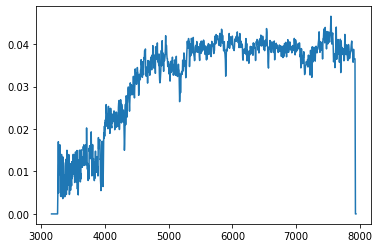

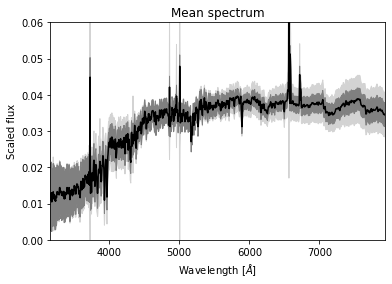

In [2]:
#%%
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from numpy.linalg import inv
from numpy.linalg import slogdet
import pandas as pd
#%% Load full data set
data = np.load('spec4000error.npz')

#%% Calculating wavlength grid from coefficients

log_wavelengths = data['coeff0'] + data['coeff1'] * np.arange(0, 1000, 1)
wavelengths = [10**i for i in log_wavelengths]

#%% Selecting only galaxies (spec_cln = 2)

galaxy_ind = data['spec_cln'] == 2
X = data['spectra'][galaxy_ind]
subclass = data['lineindex_cln'][galaxy_ind]
z = data['z'][galaxy_ind]
z_err = data['zerr'][galaxy_ind]
spec_err = data['spec_err'][galaxy_ind]

#%% Set any negative spikes in flux to zero and set the corresponding error to zero

neg_ind = X <= 0.
X[neg_ind] = 0.
spec_err[neg_ind] = 0.

#%% Set zero fluxes to NaN

X_nonan = X.copy()
zero_ind = X == 0.
X[zero_ind] = np.NaN

#%% Set all zero flux errors to NaN

zero_err_ind = spec_err == 0.
spec_err[zero_err_ind] = np.NaN

#%% Normalise spectrum
X_normal, norm = preprocessing.normalize(X_nonan, return_norm=True)
X_norm_zeros = np.copy(X_normal)

#%% Plot an example spectrum in the data
plt.figure()
plt.plot(wavelengths,X_normal[4])
plt.show()

#%% Set all zero normalised fluxes to nan
zero_norm_ind = X_normal == 0.
X_normal[zero_norm_ind] = np.NaN

#%% Transform errors due to corresponding normalisation
spec_err_T = np.transpose(spec_err)
spec_err_norm_T = np.divide(spec_err_T,norm)
spec_err_norm = np.transpose(spec_err_norm_T)

#%% Spectra errors with infs instead of nans
df = pd.DataFrame(spec_err_norm)
df_inf = df.fillna(np.inf)
spec_err_norm_inf = df_inf.to_numpy()


#%% Plot mean spectrum
mu = np.nanmean(X_normal, axis=0)
std = np.nanstd(X_normal, axis=0)
#mu = X_norm_zeros.mean(0)
#std = X_norm_zeros.std(0)
mean_err = np.nanmean(spec_err_norm, axis=0)
plt.figure()
plt.plot(wavelengths, mu, color = 'black')
plt.fill_between(wavelengths, mu - std, mu + std , color = 'lightgrey')
plt.fill_between(wavelengths, mu - mean_err, mu + mean_err , color = 'grey')
plt.xlim(wavelengths[0], wavelengths[-1])
plt.ylim(0,0.06)
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Scaled flux')
plt.title('Mean spectrum')
plt.show()

#%% Apply PCA
pca = PCA(n_components=1000)
X_red = pca.fit_transform(X_norm_zeros)

#%% Fill spectra minus mean to be filled with zeros at nan values

X_mu = X_normal - mu
df2 = pd.DataFrame(X_mu)
df2_zeros = df2.fillna(0.)
X_mu_zeros = df2_zeros.to_numpy()

In [33]:
W_0 = pca.components_

def objective_function1(W,n1,n2):
    W_T = np.transpose(W)

    spec_err1 = spec_err_norm_inf[n1:n2]
    spec_err1_nan = spec_err_norm[n1:n2]
    
    l_n = np.zeros([np.shape(spec_err1)[0]])
    
    for i in range(np.shape(spec_err1)[0]):
        sig_inv = np.diagflat(spec_err1[i]**(-2))
        M = np.identity(np.shape(W)[0]) + np.matmul(W_T,np.matmul(sig_inv,W))
    #    print(i)
        M_inv = inv(np.identity(np.shape(W)[0]) + np.matmul(W_T,np.matmul(sig_inv,W)))

        C_inv = sig_inv -  np.matmul(sig_inv,np.matmul(W,np.matmul(M_inv,np.matmul(W_T,sig_inv))))

        sign_M, logdet_M = slogdet(M)

        logdet_sig = np.nansum(np.log(spec_err1_nan[i]**(-2)))
        l_n[i] = -500*np.log(2*np.pi) - 0.5*(sign_M*logdet_M - logdet_sig) - 0.5*np.matmul(np.array([(X_mu_zeros[i])]),np.matmul(C_inv,(X_mu_zeros[i])))[0]
    
    ln = np.nansum(l_n)
    
    return -ln

In [34]:
objective_function1(W_0,0,3872)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in power
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/numpy/linalg/linalg.py:2057: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in power
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in matmul
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in matmul
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in power
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in power


2.900424274800388e+28